# Install MM Detection and try simple inference

<img src=https://i.imgur.com/wTUbVBB.png  width="400">

MMDetection 是商湯和港中文大學針對物件偵測推出的一個開源工具箱，它基於 PyTorch 實現了大量的物件偵測算法，目前支援了 11 種 Backbone、56 種物件偵測算法(還在更新)：

- Backbone: VGG、ResNet、Swin 等
- Anchor-based: R-CNN 系列、YOLOv3、SSD、RetinaNet 等
- Anchor-free: FCOS、ATSS、YOLOX 等
- Transformer: DETR 等

這個工具箱把資料集建構、模型搭建、訓練策略等過程都封裝成了模塊，通過模塊調用的方式，能夠以很少的代碼量實現一個新算法，大大提高了代碼複用率。

其他說明可以參考README.md

## 1.安裝 MM Detection

推薦使用 MIM 來安裝 MMDetection

In [1]:
!pip install openmim
!mim install mmdet

     |████████████████████████████████| 82 kB 135 kB/s eta 0:00:01
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=0baa01dc0f9f9238cc589df55c6a843aa9a3aaaf015b93955a256553480373e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpjjcx7jzb/mmdetection'...
remote: Enumerating objects: 24787, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24787 (delta 1), reused 5 (delta 0), pack-reused 24771
Receiving objects: 100% (24787/24787), 37.71 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (17364/17364), done.
Note: checking out '73b4e65a6a30435ef6a35f405e3474a4

會自動安裝dependent的套件，但pytorch要先裝好歐

後面就可以來試跑Prime Sample Attention (PISA) in Object Detection 模型順便驗證安裝

## 2.下載預訓練模型

使用```mim download --config 模型設定名稱```指令可以下載指定的設定檔、還有相應的預訓練模型。

若加上```--dest 位置```可以指定下載的位置，"."就是開啟這份code的位置。

載一遍就好了，但若是在Colab上網頁重開要重載

In [1]:
!mim download mmdet --config pisa_faster_rcnn_x101_32x4d_fpn_1x_coco --dest ./downloads

processing pisa_faster_rcnn_x101_32x4d_fpn_1x_coco...
pisa_faster_rcnn_x101_32x4d_fpn_1x_coco-e4accec4.pth exists in /home/jovyan/course/pisa-simple-example/downloads
Successfully dumped pisa_faster_rcnn_x101_32x4d_fpn_1x_coco.py to /home/jovyan/course/pisa-simple-example/downloads


In [1]:
# !mim download mmdet --config faster_rcnn_x101_32x4d_fpn_1x_coco --dest ./downloads

processing faster_rcnn_x101_32x4d_fpn_1x_coco...
  [####################################]  100%          
Successfully downloaded faster_rcnn_x101_32x4d_fpn_1x_coco_20200203-cff10310.pth to /home/jovyan/course/pisa-simple-example
Successfully dumped faster_rcnn_x101_32x4d_fpn_1x_coco.py to /home/jovyan/course/pisa-simple-example


若想試試其他模型可以到資料中路徑中去查找 https://github.com/open-mmlab/mmdetection/tree/master/configs

mmdet可以用很簡單的工具```init_detector(設定檔名稱,預訓練weight路徑或網址, device=指定運行的裝置)```來將模型載入指定裝置例如'cpu'或者'cuda'。

In [2]:
from mmdet.apis import init_detector, inference_detector,show_result_pyplot

config_file = './downloads/pisa_faster_rcnn_x101_32x4d_fpn_1x_coco.py'
checkpoint_file ="./downloads/pisa_faster_rcnn_x101_32x4d_fpn_1x_coco-e4accec4.pth"
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)

load checkpoint from local path: ./downloads/pisa_faster_rcnn_x101_32x4d_fpn_1x_coco-e4accec4.pth


model載入後除了一般Pytorch屬性之外還有很多mmdet自己家的屬性，可以用dir(model)慢慢研究

In [3]:
# 看一下預訓練模型有多少class，範例是用coco訓練的
len(model.CLASSES)

80

下載一下資料吧

In [4]:
!mkdir -p data/coco
!curl -L "https://public.roboflow.com/ds/teSUuBdtOy?key=MSfxYe5Fz3" > data/coco/roboflow.zip
!unzip -f data/coco/roboflow.zip -d data/coco
!rm -rf data/coco/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0    772      0  0:00:01  0:00:01 --:--:--   773
100 78.6M  100 78.6M    0     0  24.2M      0  0:00:03  0:00:03 --:--:-- 56.7M
Archive:  data/coco/roboflow.zip


設定一個檔案來隨機觀看train資料夾用模型推論完後結果

In [5]:
from glob import glob
from numpy.random import choice
imgs=glob('data/coco/train/*.jpg')
def random_show_inference(model,
                      score_thr=0.2,
                      font_size=32):
# inference the demo image
    # 選照片
    img=choice(imgs)
    # 推論結果
    result = inference_detector(model, img)
    # 篩出有被model判斷出來的類別，並列表置信度
    list_contents=lambda rs: (model.CLASSES[rs[0]],list(rs[1][:,-1])) if len(rs[1])!=0 else None
    content=[_ for _ in map(list_contents,enumerate(result)) if _!=None]
    print(*content,sep="\n")
    # 取一個置信度閾值並畫出結果
    model.show_result(img, result,
                      score_thr=score_thr,
                      show=True,
                      text_color=(200, 200, 200),
                      font_size=font_size)

('bottle', [0.5869014, 0.1349812, 0.07945618, 0.061154854, 0.056490004])
('dining table', [0.12267315])
('sink', [0.33061627])


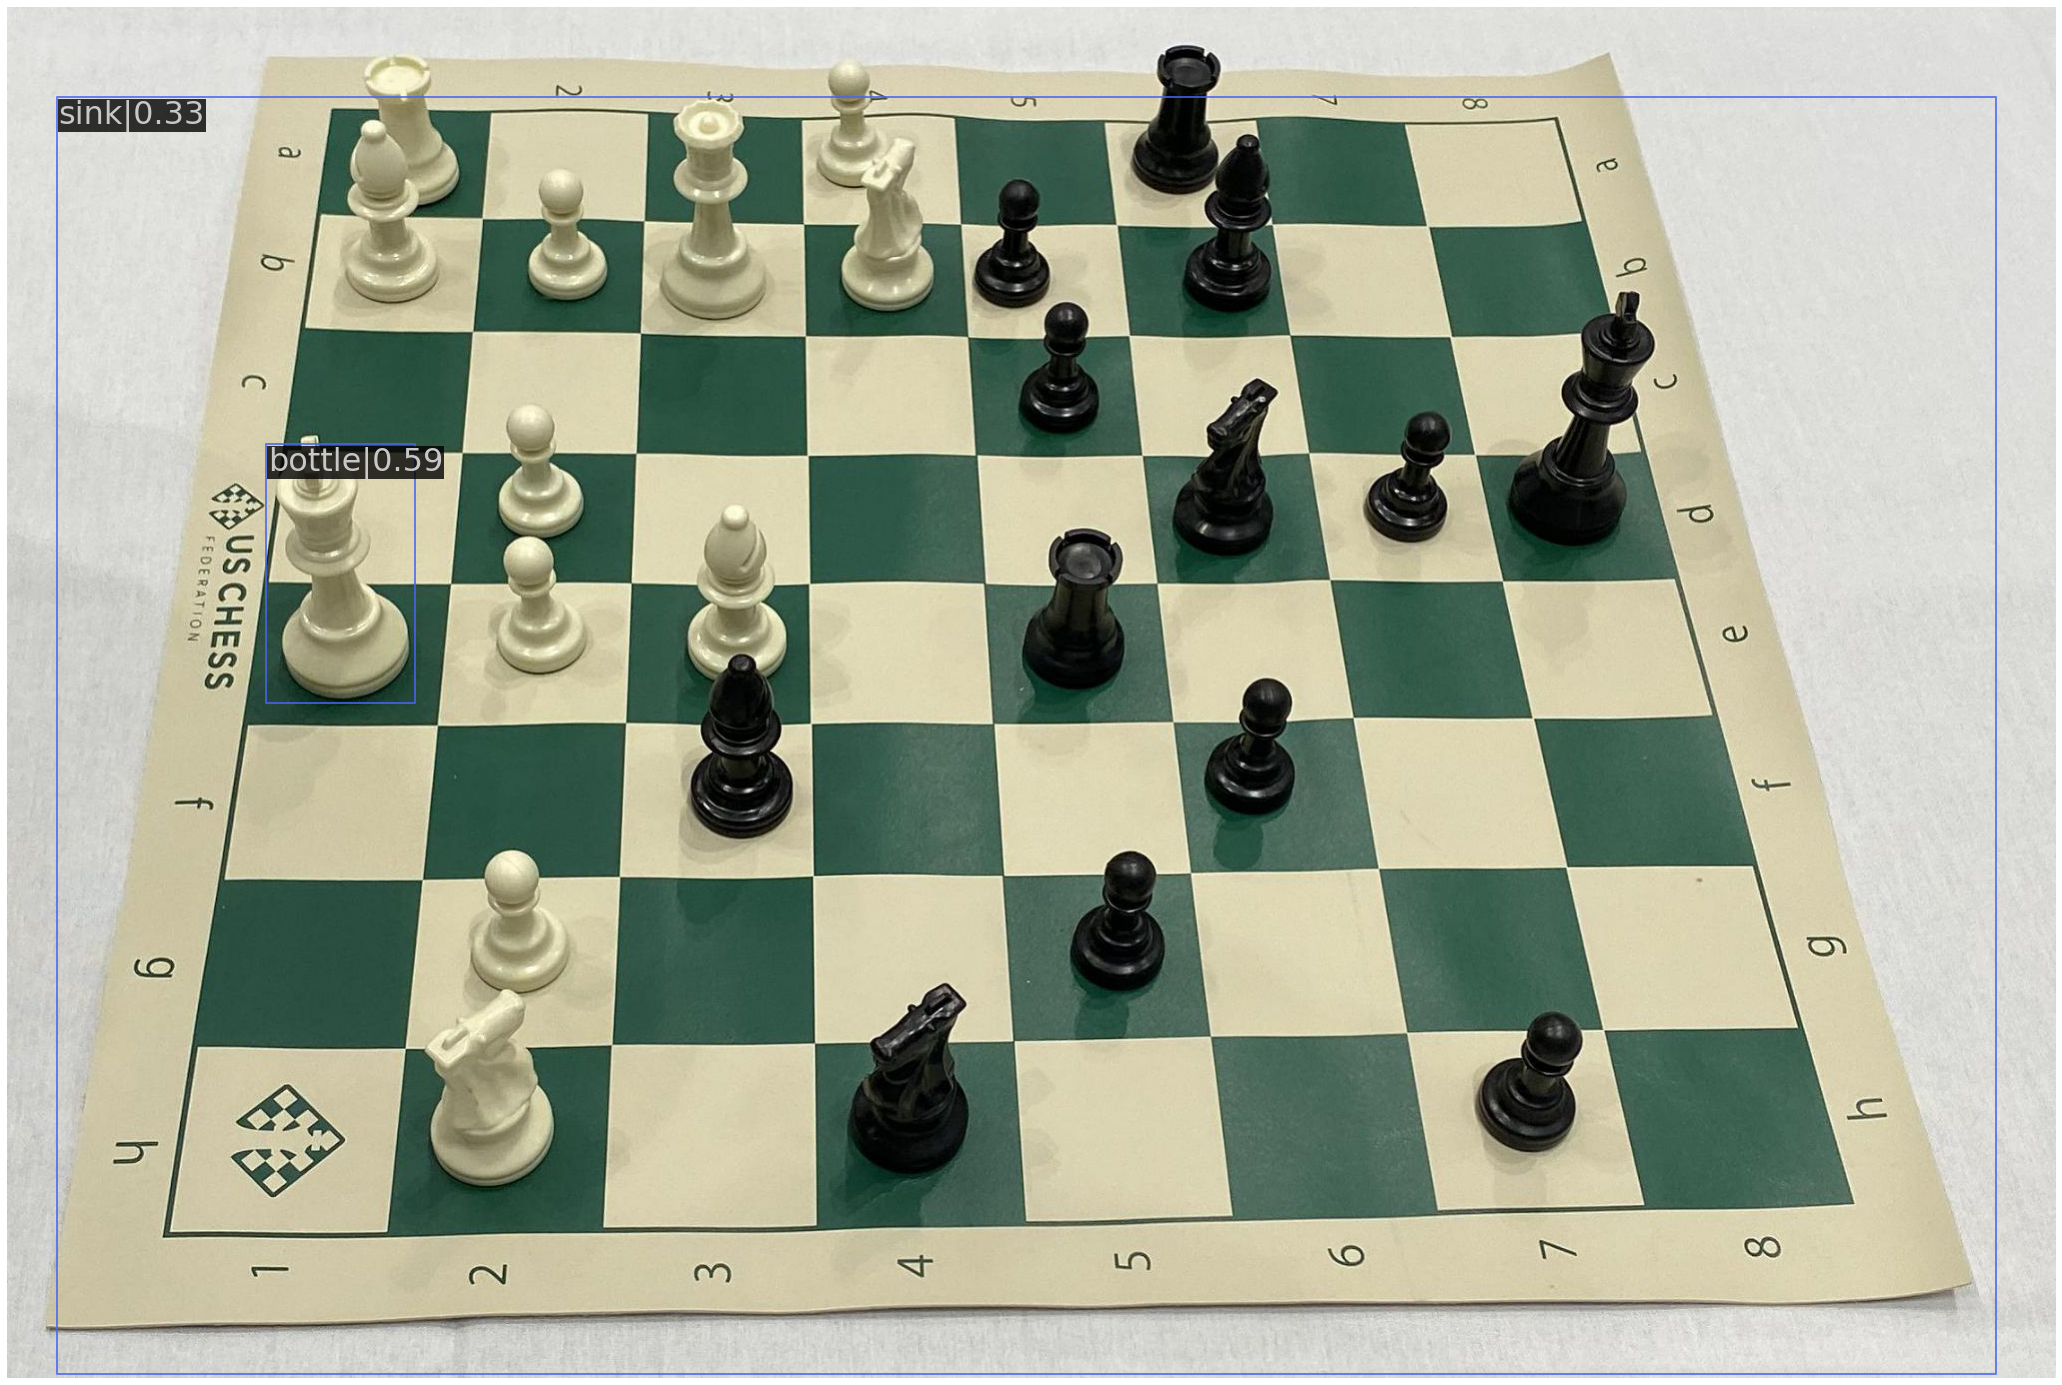

In [8]:
random_show_inference(model)

## Exercise

1. 請修改threshold試試看對inference有何影響

In [ ]:
#hint
random_show_inference(???)

2. 請試著使用其他的模型設定跑跑看

In [ ]:
#hint: 
# 參考config裡面現成的 config組合 https://github.com/open-mmlab/mmdetection/tree/master/configs
# 參考model zoo https://mmdetection.readthedocs.io/en/v2.21.0/model_zoo.html
!mim ?????
model = ????
random_show_inference(model)

## Reference

* [MMDetection Github](https://github.com/open-mmlab/mmdetection)
* [MMDetection 官方說明](https://mmdetection.readthedocs.io/en/v2.21.0/)
* [我們的github](https://github.com/ShuYuHuang/pisa-simple-example)